In [1]:
import json
import pandas as pd

# Charger le JSON
with open("data/facebook_large/musae_facebook_features.json", "r") as f:
    node_features = json.load(f)

# Construction des tuples (node, feature)
rows = []
for node, features in node_features.items():
    for feat in features:
        rows.append((int(node), feat))

# Création du DataFrame binaire
df = pd.DataFrame(rows, columns=["id", "feature"])
binary_df = pd.crosstab(df["id"], df["feature"]).astype(int)

target_df = pd.read_csv("data/facebook_large/musae_facebook_target.csv")

# Vérifier les colonnes du fichier cible
print(target_df.shape)

# Ajouter la colonne target au DataFrame binaire
# binary_df = binary_df.merge(target_df, left_index=True, right_on="id")

# Résultat
print(binary_df.shape)

(22470, 4)
(22470, 4714)


In [2]:
binary_df.head()

feature,0,1,2,3,4,5,6,7,8,9,...,4704,4705,4706,4707,4708,4709,4710,4711,4712,4713
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(4714,)


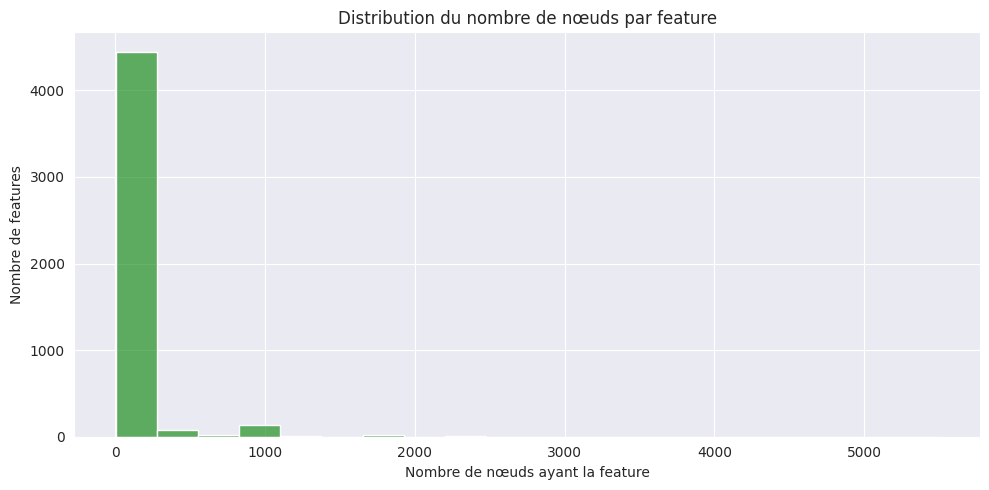

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Somme des 1s par colonne (= combien de nœuds ont cette feature)
feature_sums = binary_df.sum(axis=0)

# Optionnel : trier les sommes (pas obligatoire pour histplot)
# feature_sums = np.sort(feature_sums)
print(feature_sums.shape)

plt.figure(figsize=(10, 5))
sns.set_style("darkgrid")
sns.histplot(feature_sums, bins=20, color='green', alpha=0.6)

plt.xlabel("Nombre de nœuds ayant la feature")
plt.ylabel("Nombre de features")
plt.title("Distribution du nombre de nœuds par feature")
plt.tight_layout()
plt.show()



### link prediction

In [4]:
import networkx as nx
import pandas as pd
import node2vec as n2v

# Charger le fichier d'adjacence
adjacency_df = pd.read_csv("data/facebook_large/musae_facebook_edges.csv")
# Convertir le DataFrame en graph
graph = nx.from_pandas_edgelist(adjacency_df, source="id_1", target="id_2")
print(graph)

/home/gaetan/venvs/graphAI/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Graph with 22470 nodes and 171002 edges


In [5]:
# compute sub graph based on random walk
import random
random.seed(42)


def random_walk(graph, start_node, walk_length=10):
    """
    Perform a random walk on the graph starting from a given node.
    """
    walk = [start_node]
    for _ in range(walk_length - 1):
        neighbors = list(graph.neighbors(walk[-1]))
        if not neighbors:
            break
        walk.append(random.choice(neighbors))
    return walk

def compute_sub_graph(graph, walk_length=10, num_walks=5, pourcentage=0.5):
    """
    Compute a subgraph based on random walks from a given node.
    """
    node = random.choice(list(graph.nodes()))
    walks = []
    for _ in range(num_walks):
        walk = random_walk(graph, node, walk_length)
        walks.append(walk)
        node = random.choice(walk)
    
    # Create a subgraph based on the random walks
    sub_graph = nx.Graph()
    
    for walk in walks:
        for i in range(len(walk) - 1):
            u, v = walk[i], walk[i + 1]
            if graph.has_edge(u, v):
                sub_graph.add_edge(u, v)
    
    # # Filter edges based on the percentage
    # edges_to_remove = int(len(sub_graph.edges()) * (1 - pourcentage))
    # edges_to_remove = sorted(sub_graph.edges(), key=lambda x: graph.degree[x[0]])[:edges_to_remove]
    
    # sub_graph.remove_edges_from(edges_to_remove)
    
    return sub_graph

subgraph = compute_sub_graph(graph, walk_length=40, num_walks=30)
print(subgraph)


Graph with 925 nodes and 1052 edges


In [6]:
#node 2 vec
load = False

if load:
    # Charger le modèle existant
    model = n2v.Word2Vec.load("data/facebook_large/embeddings.emb")
else:
    node2vec = n2v.Node2Vec(subgraph, dimensions=30, walk_length=30, num_walks=50, workers=4)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    embeddings = model.wv
    # Sauvegarder les embeddings
    # embeddings.save("data/facebook_large/embeddings.emb")

# exempole
node_id = random.choice(list(subgraph.nodes()))
node_vector = embeddings[str(node_id)]
print(f"embedding for node {node_id}: {node_vector}")


Generating walks (CPU: 4): 100%|██████████| 12/12 [00:00<00:00, 12.53it/s]


embedding for node 21713: [-0.5557565  -0.7204129  -0.25170198 -0.40488335  0.5330032   1.3684294
 -0.28904793 -0.10418691 -0.5138936   0.19668575 -0.5084574  -0.74535865
  0.5573127  -0.5553302  -1.6381626   0.6063692   1.0294731  -0.57037455
 -1.0094     -0.16220929  0.39461255 -0.8444871  -0.8546709  -0.8443561
  0.76345533  0.7953352   0.07738779  0.64413434  0.18418822 -1.956693  ]


In [7]:
# cosine similarity
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Fonction pour prédire les liens
def predict_links(embeddings, node1, node2):
    embedding1 = embeddings[str(node1)].reshape(1, -1)
    embedding2 = embeddings[str(node2)].reshape(1, -1)
    similarity = cosine_similarity(embedding1, embedding2)
    return similarity[0][0]

#exemple 2 edges connectés:
node1 = random.choice(list(subgraph.nodes()))
node2 = random.choice(list(subgraph.neighbors(node1)))
similarity = predict_links(embeddings, node1, node2)
print(f"Similarity between node {node1} and node {node2} (connected): {similarity}")

#exemple 2 edges non connectés:
node1 = random.choice(list(subgraph.nodes()))
node2 = random.choice(list(subgraph.nodes()))
while node2 in subgraph.neighbors(node1):
    node2 = random.choice(list(subgraph.nodes()))
similarity = predict_links(embeddings, node1, node2)
print(f"Similarity between node {node1} and node {node2} (not connected): {similarity}")

Similarity between node 5137 and node 17639 (connected): 0.9472562074661255
Similarity between node 12759 and node 6244 (not connected): 0.3878800868988037


In [8]:
# learning predictor coeff :

import numpy as np
import random as rd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Supposons que `embeddings` soit un dictionnaire où les clés sont les nœuds et les valeurs sont les embeddings
# Supposons que `edges` soit une liste de paires de nœuds (u, v) représentant les liens existants
# Supposons que `non_edges` soit une liste de paires de nœuds (u, v) représentant les non-liens
edges = [(u, v) for u, v in subgraph.edges()]
non_edges = [(u, v) for u in subgraph.nodes() for v in subgraph.nodes() if not subgraph.has_edge(u, v) and u != v]

# compute data:
sims = []
labels = []
for u, v in tqdm(edges):
    sim = predict_links(embeddings, u, v)
    sims.append(sim)
    labels.append(1)
for u,v in tqdm(rd.sample(non_edges, 10*len(edges))):
    sim = predict_links(embeddings, u, v)
    sims.append(sim)
    labels.append(0)
#shuffle les données :
sims, labels = shuffle(sims, labels)

#### détermination d'un alpha optimal pour la classification ####

X_train, x_test, y_train, y_test = train_test_split(sims, labels, test_size=0.2, random_state=42)

best_alpha = 0
best_acc = 0
for alpha in np.linspace(0,1,100):
    preds = [1 if sim > alpha else 0 for sim in X_train]
    acc = accuracy_score(y_train, preds)
    if acc > best_acc:
        best_acc = acc
        best_alpha = alpha
        
print(f"Best alpha: {best_alpha}, Best accuracy(train): {best_acc}")

#### TEST scores ####

preds_test = [1 if sim > best_alpha else 0 for sim in x_test]

print(f"\nClassification report (test):")
print(classification_report(y_test, preds_test))

100%|██████████| 10520/10520 [00:02<00:00, 4350.06it/s]


Best alpha: 0.9090909090909092, Best accuracy(train): 0.996003024738036

Classification report (test):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2120
           1       0.96      0.98      0.97       195

    accuracy                           1.00      2315
   macro avg       0.98      0.99      0.98      2315
weighted avg       1.00      1.00      1.00      2315



## classif with  logistic regression

In [18]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Fonction pour construire les caractéristiques
def build_features(embeddings, u, v):
    return  np.abs(embeddings[str(u)] - embeddings[str(v)])

# Préparer les données
X = np.array([build_features(embeddings, u, v) for u, v in edges + non_edges])
y = np.array([1] * len(edges) + [0] * len(non_edges))

# Mélanger les données
X, y = shuffle(X, y)
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Normaliser les données
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train, y_train)
# Prédire les liens
predictions = model.predict(X_test)
print("Classification report (unbalanced)")
print(classification_report(y_test,predictions))


# Entraîner un modèle de régression logistique
model = LogisticRegression(class_weight="balanced")
model.fit(X_train, y_train)
# Prédire les liens
predictions = model.predict(X_test)
print("Classification report (balanced)")
print(classification_report(y_test,predictions))

Classification report (unbalanced)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    170532
           1       0.88      0.57      0.69       198

    accuracy                           1.00    170730
   macro avg       0.94      0.78      0.84    170730
weighted avg       1.00      1.00      1.00    170730

Classification report (balanced)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    170532
           1       0.22      0.99      0.36       198

    accuracy                           1.00    170730
   macro avg       0.61      1.00      0.68    170730
weighted avg       1.00      1.00      1.00    170730

